# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


# Styles
%matplotlib inline
plt.style.use("ggplot")

In [2]:
# Import into dataframes
rawLogdf = pd.read_csv("C:/Users/jeremiahto/OneDrive/Gammon/Innovation/Digital Transformation/Project/20170901 Indoor Positioning/LabourTracking/20171215 Trial at TKP2A/scanlog/20180220CPR.csv",
                       header=0,
                       index_col=1)
# RPI006df = pd.read_csv("C:/Users/jeremiahto/OneDrive/Gammon/Innovation/Digital Transformation/Project/20170901 Indoor Positioning/LabourTracking/IndoorPositioningRecords/scanlog_0000000007e30f08.csv", names=["project", "scannerId", "datetime", "beaconAddr", "beaconRssi"], index_col=2)
rawLogdf.index = pd.to_datetime(rawLogdf.index, dayfirst=True)
rawLogdf = rawLogdf.sort_index()
rawLogdf.head()

,id,project,scannerId,beaconRssi,beaconAddr
datetime,,,,,
2018-02-05 09:35:00,{F0F461BE-3E3E-4BD0-878B-DD61734DB144},J3628,00000000db73dcea,-32,f9:79:bd:be:99:bf
2018-02-05 09:35:00,{088F2565-75E2-4788-9C45-48260C665EE6},J3628,00000000db73dcea,-32,f9:79:bd:be:99:bf
2018-02-05 09:35:00,{FCCD9FE3-5612-4889-9165-B3CA23DE78E3},J3628,00000000db73dcea,-32,f9:79:bd:be:99:bf
2018-02-05 09:35:00,{82F7D247-45FC-4AFF-B622-27EC6F18B44F},J3628,00000000db73dcea,-32,f9:79:bd:be:99:bf
2018-02-05 09:35:00,{DC9F417F-69AB-4CD6-8FE0-7C2EE888E229},J3628,00000000db73dcea,-32,f9:79:bd:be:99:bf


In [3]:
# Parameters
scannerList = ["0000000092c5c041", "00000000db73dcea", "0000000007e30f08"]  #RPI-001,005,006
scannerThresRev = [-100, -100, -100]
startTime = pd.to_timedelta("00:00:00")  # To be adjusted if required
tolerance = pd.to_timedelta("00:00:21")  # The series of reading will still be considered as one continuous unit if the gap between reading does not exceed this value

rmCount = 0  # Initialise room count to zero at starttime
#uniqTime = []
cprContent = []  # Chiller Plant Room (cpr)
#cprContentCount = []

In [4]:
startDate = pd.to_datetime(input("Please provide the start date: [yyyy-mm-dd] ")) + startTime

Please provide the start date: [yyyy-mm-dd] 2018-02-21


In [5]:
endDate = pd.to_datetime(input("Please provide the end date: [yyyy-mm-dd] ")) + pd.to_timedelta("1 day") + startTime

Please provide the end date: [yyyy-mm-dd] 2018-02-21


In [6]:
def countAsContinuous(beaconAddr, tolerance, uniqTime, cprContent, timenow):
    # Check if the data should be counted as one continuous reading
    rvIndexLast = None
    cprContentRv = cprContent[::-1]
    for i in range(len(cprContentRv)):
        if beaconAddr in cprContentRv[i]:
            rvIndexLast = i
            break
    if rvIndexLast == None:
        return False
    else:
        timeLastAppear = uniqTime[len(cprContent)-rvIndexLast-1]
        #print("timenow = {}".format(timenow))  # Debugging only
        #print("timeLastAppear = {}".format(timeLastAppear))  # Debugging only
        if timenow - timeLastAppear > tolerance:
            return False
        else:
            return True

In [7]:
# Filter beacons
Logdf = rawLogdf[rawLogdf.beaconAddr.isin(["f9:79:bd:be:99:bf", "c8:03:83:4f:aa:42"])]  # Only for filtering certain beacons, not required in production
Logdf = Logdf[startDate:endDate]
# TODO 

In [8]:
# # rawLogdf.beaconAddr == "f9:79:bd:be:99:bf"
# '''
# row
# [0] datetime
# [1] id
# [2] project
# [3] scannerId
# [4] beaconRssi
# [5] beaconAddr
# '''

# for row in Logdf.itertuples():
#     if row[4] >= scannerThresRev[scannerList.index(row[3])]:  # Check RSSI is above threshold
#         if len(uniqTime) < 1:  # If uniqTime is empty, add stuff!
#             uniqTime.append(row[0])
#             cprContent.append([row[5]])
#         elif row[0] == uniqTime[-1]:  # If we are talking about the same scan cycle, 
#             if row[5] not in cprContent[-1]:
#                 cprContent[-1].append(row[5])
# #            else:
# #                cprContent[-1].remove(row[5])
#         elif not countAsContinuous(row[5],tolerance,uniqTime,cprContent,row[0]):
#             uniqTime.append(row[0])
#             cprContent.append(cprContent[-1])
#             if row[5] not in cprContent[-1]:
#                 cprContent[-1].append(row[5])
#             else:
#                 cprContent[-1].remove(row[5])
            

In [9]:
uniqTime = sorted(list(set(Logdf.index)))
uniqAddrGate = []

In [10]:
for i in range(len(uniqTime)):  # Reading at the gate at all the recorded times in the dataframe
    nowLogdf = Logdf[Logdf.index == uniqTime[i]]
    nowUniqAddrGate = list(set(nowLogdf.beaconAddr))
    uniqAddrGate.append(nowUniqAddrGate)
    #print(nowUniqBeaconAddr)
    #for row in nowLogdf.itertuples():
    
    # TODO: cprContent
    if len(cprContent) < 1:
        cprContent.append(nowUniqAddrGate)
    else:
        for beaconAddr in nowUniqAddrGate:
            if not countAsContinuous(beaconAddr = beaconAddr, tolerance = tolerance, uniqTime = uniqTime, cprContent = cprContent, timenow = uniqTime[i]):
                cprContent.append(cprContent[-1][:])
                if beaconAddr in cprContent[-1]:
                    cprContent[-1].remove(beaconAddr)
                else:
                    cprContent[-1].append(beaconAddr)
                print(cprContent)

timenow = 2018-02-21 17:01:00
timeLastAppear = 2018-02-21 17:00:00
not count cont
[['f9:79:bd:be:99:bf'], []]
timenow = 2018-02-21 17:10:00
timeLastAppear = 2018-02-21 17:00:00
not count cont
[['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf']]
timenow = 2018-02-21 17:16:00
timeLastAppear = 2018-02-21 17:10:00
not count cont
[['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf'], []]
timenow = 2018-02-21 17:17:00
timeLastAppear = 2018-02-21 17:10:00
not count cont
[['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf']]
timenow = 2018-02-21 17:18:00
timeLastAppear = 2018-02-21 17:17:00
not count cont
[['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf'], []]
timenow = 2018-02-21 17:19:00
timeLastAppear = 2018-02-21 17:17:00
not count cont
[['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf'], [], ['f9:79:bd:be:99:bf']]
timenow = 2018-02-21 17:20:00
timeLastAppear = 2018-02-21 17:19:00
not count cont
[['f9:79:bd:be:99:bf'], [],

In [16]:
cprContentCount = []
for i in range(len(cprContent)):
    cprContentCount.append(len(cprContent[i]))
cprContentCount

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [27]:
summarydf = pd.DataFrame({"Gate Reading": uniqAddrGate,
                         "Beacons in Room": cprContent,
                         "Room Beacon Count": cprContentCount}, index = uniqTime)
summarydf.to_csv("C:\\Users\\jeremiahto\\OneDrive\\Gammon\\Innovation\\Digital Transformation\\Project\\20170901 Indoor Positioning\\LabourTracking\\20171215 Trial at TKP2A\\scanlog\\20180221\\summarydf.csv")

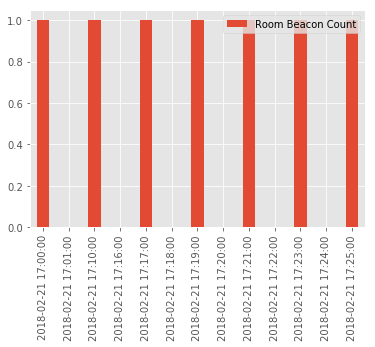

In [31]:
summarydf.plot.bar()